In [1]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import transforms3d as t3d

from icp_warm_up.tools import sync_time_stamps
from tqdm import tqdm

dataset = 21

In [2]:
def image_to_pc(bgr_img, disp_img):
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    # From writeup, compute correspondence
    height, width = disp_img.shape

    dd = np.array(-0.00304 * disp_img + 3.31)
    depth = 1.03 / dd
    mesh = np.meshgrid(np.arange(0, height), np.arange(0, width), indexing='ij')  
    i_idxs = mesh[0].flatten()
    j_idxs = mesh[1].flatten()

    rgb_i = np.array((526.37 * i_idxs + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  # force int for indexing
    rgb_j = np.array((526.37 * j_idxs + 16662) / 585.051, dtype=np.int32)

    # Some may be out of bounds, just clip them
    rgb_i = np.clip(rgb_i, 0, height - 1)
    rgb_j = np.clip(rgb_j, 0, width - 1)

    colors = rgb_img[rgb_i, rgb_j]

    # Let's visualize the image using our transformation to make sure things look correct (using bgr for opencv)
    bgr_colors = bgr_img[rgb_i, rgb_j]
    cv2.imshow("color", bgr_colors.reshape((height, width, 3)))

    uv1 = np.vstack([j_idxs, i_idxs, np.ones_like(i_idxs)])
    K = np.array([[585.05, 0, 242.94],
                  [0, 585.05, 315.84],
                  [0, 0, 1]])

    # Project images to 3d points
    points = depth.flatten() * (np.linalg.inv(K) @ uv1)

    oRr = np.array([[0, -1, 0],
                    [0, 0, -1],
                    [1, 0, 0]])
    # We want rRo because we have points in optical frame and want to move them to the regular frame.
    points = oRr.T @ points

    return points, colors

In [3]:
num_images = len(os.listdir(f"../dataRGBD/RGB{dataset}"))
print(num_images)

# Reading the data
with np.load("../data/Hokuyo%d.npz"%dataset) as data:
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans
with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images

# Syncing everything with the disparity images
synced_lidar = sync_time_stamps(disp_stamps, lidar_stamps)
synced_rgb = sync_time_stamps(disp_stamps, rgb_stamps)

print(synced_lidar.shape, synced_rgb.shape, disp_stamps.shape)

2112
(2188,) (2188,) (2188,)


Testing the projection in the easiest scenario

(3, 307200)
(307200, 3)


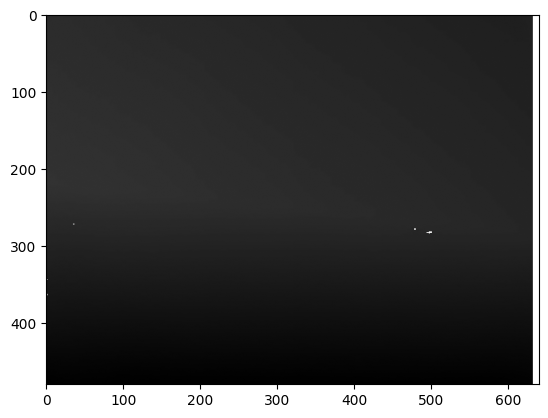

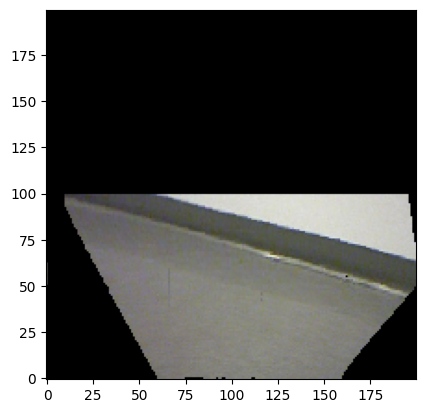

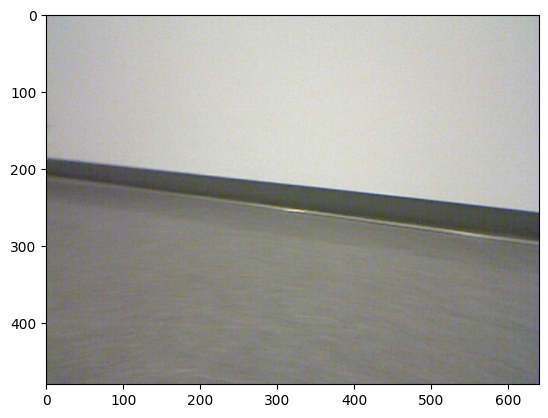

In [4]:
# Generate sample pc from disparity images
img_ind = 1630
# IMREAD_UNCHANGED ensures we preserve the precision on depth
disp_img = cv2.imread(f"../dataRGBD/Disparity{dataset}/disparity{dataset}_{img_ind}.png", cv2.IMREAD_UNCHANGED)

# Note that cv2 imports as bgr, so colors may be wrong.
bgr_img = cv2.imread(f"../dataRGBD/RGB{dataset}/rgb{dataset}_{synced_rgb[img_ind] + 1}.png")

points, colors = image_to_pc(bgr_img, disp_img)
print(points.shape)
print(colors.shape)
# Creating a map from the 3d points
img = np.zeros((200, 200, 3), dtype=np.uint8)

points[0, :] -= np.min(points[0, :]) # 0 based
points[1, :] -= np.min(points[1, :]) # 0 based
points[2, :] -= np.min(points[2, :]) # 0 based

range_x = np.max(points[0, :]) - np.min(points[0, :])
range_y = np.max(points[1, :]) - np.min(points[1, :])
range_z = np.max(points[2, :]) - np.min(points[2, :])

points[0, :] *= (190 / range_x) # Scaling to image resolution
points[1, :] *= (190 / range_y) # Scaling to image resolution
points[2, :] *= (190 / range_z) # Scaling to image resolution

for i in range(points.shape[1]):
    x = int(points[2, i])
    y = int(points[1, i])
    if x < 100:
        img[x, -y] = colors[i]

# Plotting all images
plt.figure()
plt.imshow(disp_img, cmap='gray')
plt.figure()
plt.imshow(img, origin='lower')
plt.figure()
plt.imshow(cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB))

In [5]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.T)
pcd.colors = o3d.utility.Vector3dVector(colors / 255)  # open3d expects color channels 0-1, opencv uses uint8 0-255

origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.5)  # visualize the camera regular frame for reference.

o3d.visualization.draw_geometries([pcd, origin])  # display the pointcloud and origin

2025-02-28 21:51:46.087 python[77319:64730158] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-28 21:51:46.087 python[77319:64730158] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Occupancy map

In [6]:
# Reading the pose transformations from npy files
poses = np.load(f"./icp_warm_up/icp_poses_{dataset}.npy")

with np.load("../data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]     # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

    # Clipping the ranges
    lidar_ranges[lidar_ranges < lidar_range_min] = 0
    lidar_ranges[lidar_ranges > lidar_range_max] = 0
    lidar_ranges = lidar_ranges.T

# Extracting point clouds from lidar data
def extract_pc(lidar_ranges, lidar_angle_increment):
    pc = []
    for i in range(len(lidar_ranges)):
        ranges = lidar_ranges[i]
        angles = np.arange(lidar_angle_min, lidar_angle_max + 1e-6, lidar_angle_increment)
        x = ranges * np.cos(angles)
        y = ranges * np.sin(angles)
        z = np.zeros_like(x)

        # Removing all zeros
        x = x[ranges != 0]
        y = y[ranges != 0]
        z = z[ranges != 0]
        pc.append(np.stack([x, y, z], axis=1))
    return pc

pc = extract_pc(lidar_ranges, lidar_angle_increment)
print(len(pc))

4785


/var/folders/1y/87vkwc9x32lcthv8n1nxqhz80000gn/T/ipykernel_77319/885492550.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angles = np.arange(lidar_angle_min, lidar_angle_max + 1e-6, lidar_angle_increment)


Let's take a look at Lidar scans at different time steps

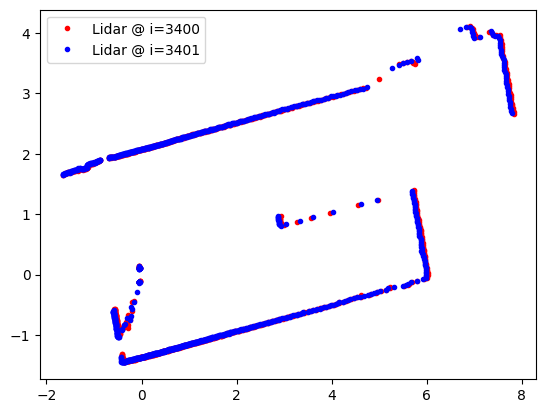

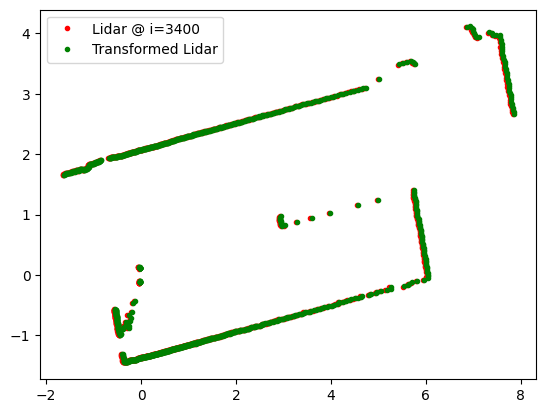

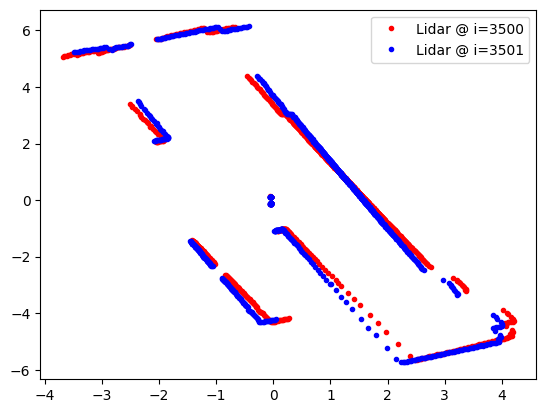

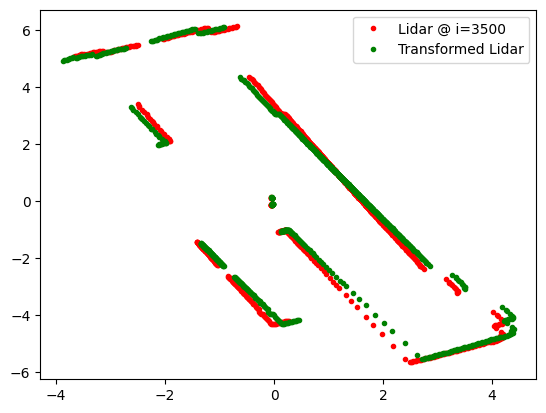

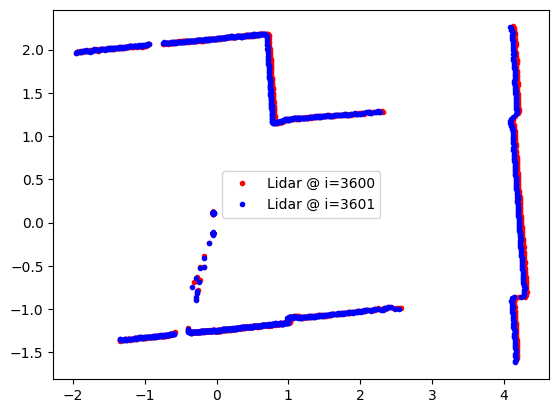

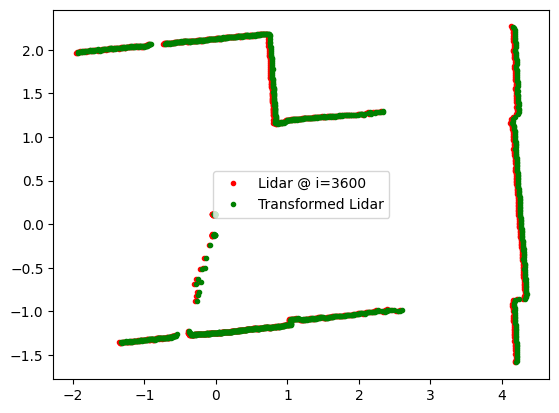

In [7]:
current_pose = np.eye(4)
for i in range(3400, 3700, 100):
    plt.plot(pc[i][:, 0], pc[i][:, 1], 'r.')
    plt.plot(pc[i + 1][:, 0], pc[i + 1][:, 1], 'b.')
    plt.legend([f"Lidar @ i={i}", f"Lidar @ i={i + 1}"])
    plt.show()
    current_pc = pc[i]
    current_pose = np.linalg.inv(poses[i - 1]) @ poses[i] # Poses are accumulated from the first frame
    
    current_pc = current_pc.T
    # Adding the 1s for the homogeneous coordinates
    current_pc = np.vstack([current_pc, np.ones_like(current_pc[0])])
    # Transforming the point cloud to the world frame
    current_pc = current_pose @ current_pc
    current_pc = current_pc[:3]
    plt.plot(pc[i][:, 0], pc[i][:, 1], 'r.')
    plt.plot(current_pc[0], current_pc[1], 'g.')
    plt.legend([f"Lidar @ i={i}", "Transformed Lidar"])
    plt.show()

Transformations look great! Let's move forward with the occupancy map

In [8]:
from pr2_utils import test_bresenham2D

test_bresenham2D()

Testing bresenham2D...
...Test passed.
1000 raytraces: --- 0.022237062454223633 seconds ---


100%|██████████| 4785/4785 [01:11<00:00, 67.00it/s]
/var/folders/1y/87vkwc9x32lcthv8n1nxqhz80000gn/T/ipykernel_77319/1870787318.py:49: RuntimeWarning: overflow encountered in exp
  occupancy_map = 1 / (1 + np.exp(odds_map))


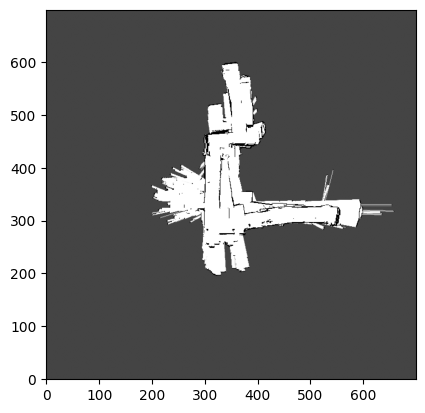

In [9]:
from pr2_utils import bresenham2D
from tqdm import tqdm

center = 350

# Intially all cells are empty
odds_map = np.ones((center * 2, center * 2, 1), dtype=np.float32)
occupancy_map = np.zeros((center * 2, center * 2, 1), dtype=np.float32)

log = np.log(4)
ratio = 12
min_odds = -100
max_odds = -min_odds

current_pose = np.eye(4)
trajectory = []

for i in tqdm(range(len(pc))):
    current_pc = pc[i]
    current_pc = current_pc.T
    # Adding the 1s for the homogeneous coordinates
    current_pc = np.vstack([current_pc, np.ones_like(current_pc[0])])
    # Transforming the point cloud to the world frame
    current_pc = current_pose @ current_pc
    current_pc = current_pc[:3]
    # Current Coorinates in the world frame
    x_world = int(current_pose[0, 3] * ratio + center)
    y_world = int(current_pose[1, 3] * ratio + center)
    trajectory.append([x_world, y_world])
    # Creating the occupancy map
    for j in range(current_pc.shape[1]):
        x = int(current_pc[0, j] * ratio + center)
        y = int(current_pc[1, j] * ratio + center)
        # Using Bresnham to find rays
        rays = bresenham2D(x_world, y_world, x, y).T
        # Free rays
        rays = np.array(rays, dtype=np.int32)
        odds_map[rays[:, 1], rays[:, 0], 0] -= log
        # Occupied cell
        odds_map[int(y), int(x), 0] += 2 * log 

    odds_map = np.clip(odds_map, min_odds, max_odds)
    
    # Last frame
    if i != len(pc) - 1:
        current_pose = poses[i] # Poses are accumulated from the first frame

# Converting the odds map to the occupancy map
occupancy_map = 1 / (1 + np.exp(odds_map))
# Visualizing the occupancy map
plt.imshow(occupancy_map, cmap='gray', origin='lower')

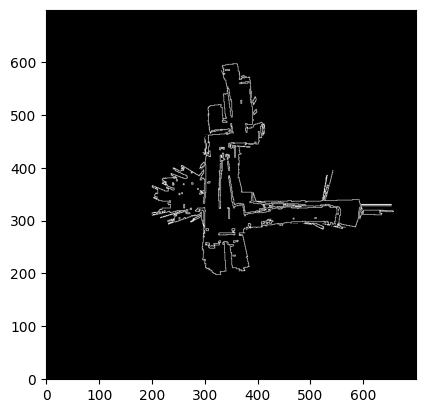

In [10]:
# Extracting the edges
edges = np.zeros_like(occupancy_map)
for i in range(1, occupancy_map.shape[0] - 1):
    for j in range(1, occupancy_map.shape[1] - 1):
        if occupancy_map[i, j] > 0.5:
            # Check if there is a free cell around
            if np.any(occupancy_map[i - 1:i + 2, j - 1:j + 2] < 0.5):
                edges[i, j] = 1
plt.imshow(edges, cmap='gray', origin='lower')

/var/folders/1y/87vkwc9x32lcthv8n1nxqhz80000gn/T/ipykernel_77319/1423368035.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("rainbow", len(trajectory))


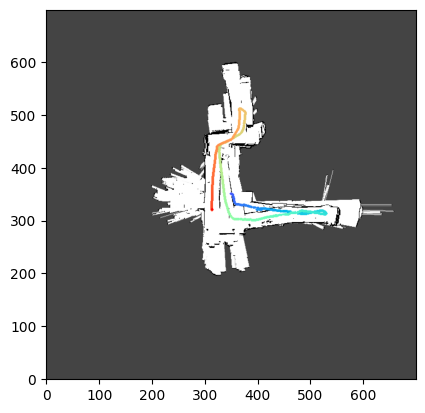

In [11]:
import matplotlib.cm as cm
# Adding the trajectory in rainbow colors to the occupancy map
def convert_occupancy_to_rgb(occupancy_map, trajectory):
    """
    Convert a (x, x, 1) B&W occupancy map to an RGB image with a trajectory in rainbow colors.
    
    Parameters:
    - occupancy_map: numpy array of shape (H, W, 1) with values 0 (free) and 1 (obstacle)
    - trajectory: list of (x, y) points representing the path
    
    Returns:
    - rgb_image: numpy array of shape (H, W, 3) representing the colored map
    """
    # Convert single-channel occupancy map to 3-channel grayscale image
    rgb_image = np.repeat(occupancy_map * 255, 3, axis=2).astype(np.uint8)

    # Generate colors for the trajectory using a rainbow colormap
    cmap = cm.get_cmap("rainbow", len(trajectory))
    colors = [tuple(int(c * 255) for c in cmap(i)[:3]) for i in range(len(trajectory))]

    # Draw the trajectory
    for i, (x, y) in enumerate(trajectory):
        cv2.circle(rgb_image, (x, y), radius=2, color=colors[i], thickness=-1)

    return rgb_image


rgb_image = convert_occupancy_to_rgb(occupancy_map, trajectory)
plt.imshow(rgb_image, origin='lower')

100%|██████████| 2186/2186 [01:27<00:00, 24.93it/s]
/var/folders/1y/87vkwc9x32lcthv8n1nxqhz80000gn/T/ipykernel_77319/1777427660.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("rainbow", len(trajectory))


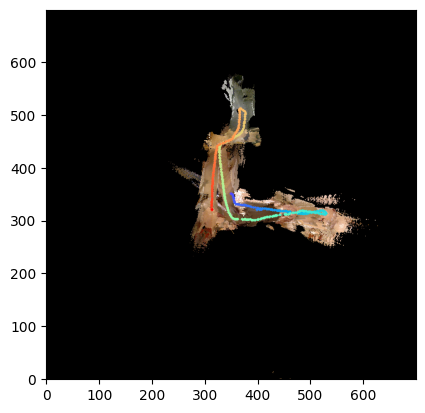

In [12]:
map_center = 350
map_ratio = 12
texture_map = np.zeros((2 * map_center, 2 * map_center, 3), dtype=np.uint8)

# Adding the trajectory in rainbow colors to the occupancy map
def convert_texture_to_rgb(texture_map, trajectory):
    """
    Convert a (x, x, 3) texture map to an RGB image with a trajectory in rainbow colors.
    
    Parameters:
    - text_map: numpy array of shape (H, W, 3)
    - trajectory: list of (x, y) points representing the path
    
    Returns:
    - rgb_image: numpy array of shape (H, W, 3) representing the colored map
    """

    # Generate colors for the trajectory using a rainbow colormap
    cmap = cm.get_cmap("rainbow", len(trajectory))
    colors = [tuple(int(c * 255) for c in cmap(i)[:3]) for i in range(len(trajectory))]

    # Draw the trajectory
    for i, (x, y) in enumerate(trajectory):
        cv2.circle(texture_map, (x, y), radius=2, color=colors[i], thickness=-1)

    return texture_map

trajectory_texture = []

#  The depth camera is located at 
# (0.18, 0.005, 0.36) m with respect to the robot center and has orientation with roll 0
# rad, pitch 0.36 rad, and yaw 0.021 rad.
kinect_offset = np.array([-0.18, -0.005, -0.36])
kinect_rotation = t3d.euler.euler2mat(0, -0.36, -0.021)
kinect_pose = np.eye(4)
kinect_pose[:3, :3] = kinect_rotation
kinect_pose[:3, 3] = kinect_offset
# kinect_pose = np.linalg.inv(kinect_pose)

pose_synced_lidar = sync_time_stamps(disp_stamps, lidar_stamps)
pose_synced_rgb = sync_time_stamps(disp_stamps, rgb_stamps)

for i in tqdm(range(1, len(synced_lidar) - 1)):
    ind_lidar = synced_lidar[i]
    ind_rgb = synced_rgb[i] + 1
    # IMREAD_UNCHANGED ensures we preserve the precision on depth
    disp_img = cv2.imread(f"../dataRGBD/Disparity{dataset}/disparity{dataset}_{i}.png", cv2.IMREAD_UNCHANGED)
     # Note that cv2 imports as bgr, so colors may be wrong.
    bgr_img = cv2.imread(f"../dataRGBD/RGB{dataset}/rgb{dataset}_{ind_rgb}.png")

    # Get the pose
    pose = poses[ind_lidar]

    trajectory_texture.append([int(pose[0, 3] * map_ratio + map_center), int(pose[1, 3] * map_ratio + map_center)])
    # Generate sample pc from disparity images
    points, colors = image_to_pc(bgr_img, disp_img)
    # Transform the points to the world frame
    points_4d = np.vstack([points, np.ones_like(points[0, :])])
    
    # points_4d = kinect_pose @ points_4d
    points_4d = kinect_pose @ points_4d
    points = pose @ points_4d
    points = points[:3]

    # Filtering the points higher than a threshold
    height_threshold = 100
    colors = colors[points[2] < height_threshold, :]
    points = points[:, points[2] < height_threshold]

    points = points * map_ratio + map_center
    points = np.array(points, dtype=np.int32)
    points = np.clip(points, 0, 2 * map_center - 1)

    # Mapping the colors to the texture map in parallel
    # texture_map[points[2], points[0]] = colors

    # Mapping with x, y
    texture_map[points[1], points[0]] = colors

trajectory_texture = np.array(trajectory_texture)
texture_map = convert_texture_to_rgb(texture_map.copy(), trajectory_texture)
plt.imshow(texture_map, origin='lower')

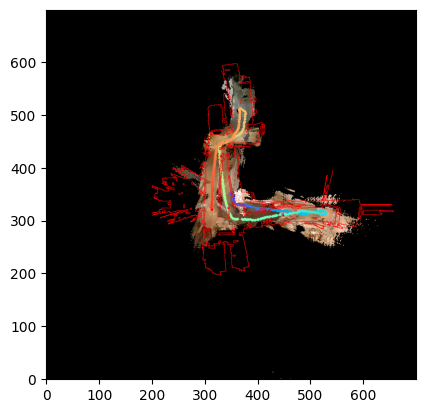

In [13]:
# Extracting the edges
edges = np.zeros_like(texture_map)
for i in range(1, occupancy_map.shape[0] - 1):
    for j in range(1, occupancy_map.shape[1] - 1):
        if occupancy_map[i, j] > 0.5:
            # Check if there is a free cell around
            if np.any(occupancy_map[i - 1:i + 2, j - 1:j + 2] < 0.5):
                edges[i, j] = [1, 1, 1]
final_map = texture_map * (1 - edges) + np.array([255, 0, 0]) * edges
plt.imshow(final_map, origin='lower')